# 0. Import libraries

The libraries used to create the data are in the following cell

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from modeling import read_data_for_training, \
                     create_linear_architecture, \
                     compile_linear_model, \
                     train_linear_model, \
                     plot_model_history, \
                     store_model, \
                     create_conv_model

2023-10-01 17:30:07.091554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 17:30:07.776675: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Define constants

This section defines constants to specify the location of the data and where the model will be stored

In [3]:
# Path to the files where the data for the training is
features_filename = "2d_surfaces"
labels_filename = "2d_coefficients"

# 2. Read data

Get train, validation and test data

In [4]:
train_features, \
train_labels, \
val_features, \
val_labels, \
test_features, \
test_labels = read_data_for_training(features_filename,
                                     labels_filename)

# 3. Define hyperparameters for neural network

In the first place define the hyperparameters of the neural network

In [5]:
# Neural network architecture hyperparameters
input_shape = train_features[0].shape
output_size = len(train_labels[0])
hidden_layer_sizes = [1024, 512, 256, 64, 32]
regularizer = keras.regularizers.L1L2(l1=0.001,l2=0.1)
hidden_activation = 'relu'
output_activation = 'linear'
use_batch_normalization = True
name = 'ConvolutionalModel'

# Compilation hyperparameters
loss_function = tf.keras.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
metric = tf.keras.metrics.MeanSquaredError()

# Training hyperparameters
epochs = 750
batch_size = 64
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=100, verbose=1)
early_stop = EarlyStopping('mean_squared_error', patience=150, verbose=1)
callbacks = [reduce_lr, early_stop]

2023-10-01 17:30:14.304418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-01 17:30:14.323470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-01 17:30:14.323675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 4. Train Network

Create the architecture

In [6]:
conv_model = create_conv_model(input_shape, output_size)
#surface_reconstructor_model = create_linear_architecture(input_shape,
#                                                         output_size,
#                                                         hidden_layer_sizes,
#                                                         regularizer,
#                                                         hidden_activation,
#                                                         output_activation,
#                                                         use_batch_normalization=use_batch_normalization,
#                                                         name=name)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 1, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8

Compile the model

In [8]:
compile_linear_model(conv_model,
                     loss_function,
                     optimizer,
                     metric
                     )

Fit the model

In [10]:
history = train_linear_model(conv_model,
                             train_features,
                             train_labels,
                             batch_size,
                             epochs,
                             val_features,
                             val_labels,
                             callbacks)

Epoch 1/750


2023-10-01 17:30:38.410853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-01 17:30:39.018479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-01 17:30:39.021235: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f39abdd1ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-01 17:30:39.021257: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-10-01 17:30:39.024923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-01 17:30:39.134335: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

750/750 [==============================] - 7s 5ms/step - loss: 9.6977 - mean_squared_error: 9.6977 - val_loss: 6.5157 - val_mean_squared_error: 6.5157 - lr: 0.0100
Epoch 2/750
750/750 [==============================] - 3s 4ms/step - loss: 5.9274 - mean_squared_error: 5.9274 - val_loss: 5.8670 - val_mean_squared_error: 5.8670 - lr: 0.0100
Epoch 3/750
750/750 [==============================] - 3s 4ms/step - loss: 5.6315 - mean_squared_error: 5.6315 - val_loss: 5.5721 - val_mean_squared_error: 5.5721 - lr: 0.0100
Epoch 4/750
750/750 [==============================] - 3s 4ms/step - loss: 5.5700 - mean_squared_error: 5.5700 - val_loss: 5.3785 - val_mean_squared_error: 5.3785 - lr: 0.0100
Epoch 5/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5135 - mean_squared_error: 5.5135 - val_loss: 5.4923 - val_mean_squared_error: 5.4923 - lr: 0.0100
Epoch 6/750
750/750 [==============================] - 4s 5ms/step - loss: 5.6743 - mean_squared_error: 5.6743 - val_loss: 5.4852 - 

750/750 [==============================] - 4s 5ms/step - loss: 4.4978 - mean_squared_error: 4.4978 - val_loss: 4.5156 - val_mean_squared_error: 4.5156 - lr: 0.0100
Epoch 48/750
750/750 [==============================] - 4s 5ms/step - loss: 4.4222 - mean_squared_error: 4.4222 - val_loss: 4.3480 - val_mean_squared_error: 4.3480 - lr: 0.0100
Epoch 49/750
750/750 [==============================] - 4s 5ms/step - loss: 4.4426 - mean_squared_error: 4.4426 - val_loss: 4.4830 - val_mean_squared_error: 4.4830 - lr: 0.0100
Epoch 50/750
750/750 [==============================] - 4s 5ms/step - loss: 4.6165 - mean_squared_error: 4.6165 - val_loss: 4.2101 - val_mean_squared_error: 4.2101 - lr: 0.0100
Epoch 51/750
750/750 [==============================] - 4s 5ms/step - loss: 4.5957 - mean_squared_error: 4.5957 - val_loss: 4.3423 - val_mean_squared_error: 4.3423 - lr: 0.0100
Epoch 52/750
750/750 [==============================] - 4s 5ms/step - loss: 4.4148 - mean_squared_error: 4.4148 - val_loss: 4.26

750/750 [==============================] - 4s 5ms/step - loss: 4.5338 - mean_squared_error: 4.5338 - val_loss: 9.6629 - val_mean_squared_error: 9.6629 - lr: 0.0100
Epoch 94/750
750/750 [==============================] - 3s 4ms/step - loss: 4.3779 - mean_squared_error: 4.3779 - val_loss: 4.3407 - val_mean_squared_error: 4.3407 - lr: 0.0100
Epoch 95/750
750/750 [==============================] - 4s 5ms/step - loss: 4.2069 - mean_squared_error: 4.2069 - val_loss: 4.2390 - val_mean_squared_error: 4.2390 - lr: 0.0100
Epoch 96/750
750/750 [==============================] - 4s 5ms/step - loss: 4.2335 - mean_squared_error: 4.2335 - val_loss: 4.0146 - val_mean_squared_error: 4.0146 - lr: 0.0100
Epoch 97/750
750/750 [==============================] - 4s 5ms/step - loss: 4.2216 - mean_squared_error: 4.2216 - val_loss: 4.1267 - val_mean_squared_error: 4.1267 - lr: 0.0100
Epoch 98/750
750/750 [==============================] - 4s 5ms/step - loss: 4.3742 - mean_squared_error: 4.3742 - val_loss: 4.58

750/750 [==============================] - 4s 5ms/step - loss: 4.0616 - mean_squared_error: 4.0616 - val_loss: 3.7976 - val_mean_squared_error: 3.7976 - lr: 0.0100
Epoch 140/750
750/750 [==============================] - 4s 5ms/step - loss: 4.0922 - mean_squared_error: 4.0922 - val_loss: 3.9975 - val_mean_squared_error: 3.9975 - lr: 0.0100
Epoch 141/750
750/750 [==============================] - 4s 5ms/step - loss: 4.3066 - mean_squared_error: 4.3066 - val_loss: 8.8429 - val_mean_squared_error: 8.8429 - lr: 0.0100
Epoch 142/750
750/750 [==============================] - 4s 5ms/step - loss: 4.1848 - mean_squared_error: 4.1848 - val_loss: 3.8803 - val_mean_squared_error: 3.8803 - lr: 0.0100
Epoch 143/750
750/750 [==============================] - 4s 5ms/step - loss: 4.0172 - mean_squared_error: 4.0172 - val_loss: 4.0971 - val_mean_squared_error: 4.0971 - lr: 0.0100
Epoch 144/750
750/750 [==============================] - 4s 5ms/step - loss: 4.1901 - mean_squared_error: 4.1901 - val_loss:

750/750 [==============================] - 3s 4ms/step - loss: 6.0767 - mean_squared_error: 6.0767 - val_loss: 6.1277 - val_mean_squared_error: 6.1277 - lr: 0.0100
Epoch 186/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0796 - mean_squared_error: 6.0796 - val_loss: 6.1301 - val_mean_squared_error: 6.1301 - lr: 0.0100
Epoch 187/750
750/750 [==============================] - 4s 5ms/step - loss: 6.1076 - mean_squared_error: 6.1076 - val_loss: 6.0792 - val_mean_squared_error: 6.0792 - lr: 0.0100
Epoch 188/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0825 - mean_squared_error: 6.0825 - val_loss: 6.0534 - val_mean_squared_error: 6.0534 - lr: 0.0100
Epoch 189/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0512 - mean_squared_error: 6.0512 - val_loss: 6.2004 - val_mean_squared_error: 6.2004 - lr: 0.0100
Epoch 190/750
750/750 [==============================] - 4s 5ms/step - loss: 6.1042 - mean_squared_error: 6.1042 - val_loss:

750/750 [==============================] - 4s 5ms/step - loss: 6.1228 - mean_squared_error: 6.1228 - val_loss: 6.0420 - val_mean_squared_error: 6.0420 - lr: 0.0100
Epoch 232/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0394 - mean_squared_error: 6.0394 - val_loss: 6.0339 - val_mean_squared_error: 6.0339 - lr: 0.0100
Epoch 233/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0711 - mean_squared_error: 6.0711 - val_loss: 6.1244 - val_mean_squared_error: 6.1244 - lr: 0.0100
Epoch 234/750
750/750 [==============================] - 4s 5ms/step - loss: 6.1000 - mean_squared_error: 6.1000 - val_loss: 6.0428 - val_mean_squared_error: 6.0428 - lr: 0.0100
Epoch 235/750
750/750 [==============================] - 4s 5ms/step - loss: 6.1415 - mean_squared_error: 6.1415 - val_loss: 6.0040 - val_mean_squared_error: 6.0040 - lr: 0.0100
Epoch 236/750
750/750 [==============================] - 4s 5ms/step - loss: 6.0233 - mean_squared_error: 6.0233 - val_loss:

750/750 [==============================] - 4s 5ms/step - loss: 5.5232 - mean_squared_error: 5.5232 - val_loss: 5.6134 - val_mean_squared_error: 5.6134 - lr: 1.0000e-03
Epoch 276/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5237 - mean_squared_error: 5.5237 - val_loss: 5.5815 - val_mean_squared_error: 5.5815 - lr: 1.0000e-03
Epoch 277/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5221 - mean_squared_error: 5.5221 - val_loss: 5.6098 - val_mean_squared_error: 5.6098 - lr: 1.0000e-03
Epoch 278/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5210 - mean_squared_error: 5.5210 - val_loss: 5.6113 - val_mean_squared_error: 5.6113 - lr: 1.0000e-03
Epoch 279/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5210 - mean_squared_error: 5.5210 - val_loss: 5.6034 - val_mean_squared_error: 5.6034 - lr: 1.0000e-03
Epoch 280/750
750/750 [==============================] - 4s 5ms/step - loss: 5.5171 - mean_squared_error

# 5. Check training process

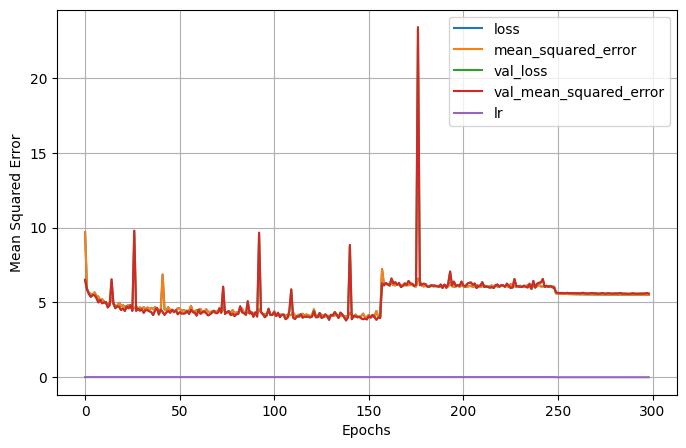

In [11]:
plot_model_history(history)

# 6. Save model and description

In [12]:
description = f"# Neural network architecture hyperparameters \n\
# Creating a Sequential model \n\
model = Sequential() \n\
input_shape = input_shape + (1, ) \n\
# Adding a convolutional layer with 32 filters, a 3x3 kernel, and 'relu' activation function \n\
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)) \n\
# Adding a max-pooling layer with a 2x2 pool size \n\
model.add(MaxPooling2D(pool_size=(2, 2)))\n\
# Adding another convolutional layer with 64 filters, a 3x3 kernel, and 'relu' activation function \n\
model.add(Conv2D(64, (3, 3), activation='relu')) \n\
# Adding another max-pooling layer with a 2x2 pool size \n\
model.add(MaxPooling2D(pool_size=(2, 2))) \n\
# Flattening the 3D output to 1D tensor for a fully connected layer \n\
model.add(Flatten()) \n\
# Adding a fully connected layer with 128 units and 'relu' activation function \n\
model.add(Dense(128, activation='relu')) \n\
# Adding the output layer with 10 units (for example, for 10 classes) and 'softmax' activation function \n\
model.add(Dense(output_size, activation='linear')) \n\
# Compiling the model with 'adam' optimizer, 'categorical_crossentropy' loss, and accuracy metric \n\
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) \n\
# Printing the summary of the model architecture \n\
model.summary() \n\
return model"

store_model(conv_model,
            'ConvolutionalModel',
            description)